In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from IPython import display
from IPython.core.display import clear_output
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from collections import OrderedDict

In [2]:
def pm(size,perm_array):
    r,c = size
    out = np.zeros((r,c))
    if r!=perm_array.shape[0]:
        raise ValueError('perm_array is not of same size as required Permutation matrix. i.e. ',r,' != ',perm_array.shape[0])
    else:
        for i in range(r):
            out[i,perm_array[i]] = 1    # for each row and coulmn have one 1. column number is dictate by randomly shuffled list
    reverse = np.linalg.inv(out)
    return out,reverse

In [3]:
r,c = 32,32
m1 = np.arange(0,r,1,np.int8)       # list having numbers from 0 to 31
m1r = np.random.permutation(m1)      # randomly shuffle the above list. no number is repeated
#np.savetxt('per_mat_arr.csv',m1r)
#m1rt = np.loadtxt('per_mat_arr.csv')
#m1rt=np.int16(m1rt)
p_m,inv = pm((r,c),m1r) 
p_m_3c = np.reshape(np.array((p_m,p_m,p_m)),(r,c,3))
p_m_3c.shape


(32, 32, 3)

In [7]:
trainTransform = torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1),
                                    torchvision.transforms.ToTensor(), 
                                    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=trainTransform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=trainTransform)
datag = 0.299*trainset.data[:,:,:,0] + 0.587*trainset.data[:,:,:,1] + 0.114*trainset.data[:,:,:,2]
testg = 0.299*testset.data[:,:,:,0] + 0.587*testset.data[:,:,:,1] + 0.114*testset.data[:,:,:,2]
labels = datag.copy()
tlabels = testg.copy()

Files already downloaded and verified
Files already downloaded and verified


In [6]:
print(trainset.data.shape)
print(labels[0].shape)
#print(labels[0]/255)

(50000, 32, 32, 3)
(32, 32, 3)


In [8]:
pmt = torch.tensor(p_m).float()
#print(pmt,trainset.data[0])
for i in range(50000):
  datag[i] = p_m @ (datag[i]@p_m)
for i in range(10000):
  testg[i] = p_m @ (testg[i]@p_m)

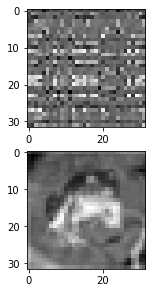

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(4,1,1)
plt.imshow(datag[0],cmap='gray')
plt.subplot(4,1,2)
plt.imshow(labels[0],cmap='gray')

In [10]:
datag = torch.tensor((datag))
datag = torch.reshape(datag,(50000,1,1,32,32)).float()
trainset.targets = torch.tensor((trainset.targets))
trainset.targets = torch.reshape(trainset.targets,(50000,1))

testg = torch.tensor((testg ))
testg  = torch.reshape(testg ,(10000,1,1,32,32)).float()
testset.targets = torch.tensor((testset.targets))
testset.targets = torch.reshape(testset.targets,(10000,1))

labels = torch.tensor((labels)).float()
tlabels = torch.tensor((tlabels)).float()

In [13]:
layers1 = OrderedDict()
layers1["1fc"] = nn.Linear( 1024,512,bias=True)
layers1["Relufc1"] = nn.ReLU()
layers1["2fc"] = nn.Linear(512,256,bias=True)
layers1["Relufc2"] = nn.ReLU()
layers1["3fc"] = nn.Linear( 256,128,bias=True)
layers1["Relufc3"] = nn.ReLU()
layers1["4fc"] = nn.Linear( 128,64,bias=True)
layers1["Relufc4"] = nn.ReLU()
layers1["5fc"] = nn.Linear( 64,128,bias=True)
layers1["Relufc5"] = nn.ReLU()
layers1["6fc"] = nn.Linear( 128,256,bias=True)
layers1["Relufc6"] = nn.ReLU()
layers1["7fc"] = nn.Linear( 256,512,bias=True)
layers1["Relufc7"] = nn.ReLU()
layers1["8fc"] = nn.Linear( 512,1024,bias=True)
layers1["Relufc8"] = nn.ReLU()
decoder = nn.Sequential(layers1)
decoder = decoder.float()
decoder

Sequential(
  (1fc): Linear(in_features=1024, out_features=512, bias=True)
  (Relufc1): ReLU()
  (2fc): Linear(in_features=512, out_features=256, bias=True)
  (Relufc2): ReLU()
  (3fc): Linear(in_features=256, out_features=128, bias=True)
  (Relufc3): ReLU()
  (4fc): Linear(in_features=128, out_features=64, bias=True)
  (Relufc4): ReLU()
  (5fc): Linear(in_features=64, out_features=128, bias=True)
  (Relufc5): ReLU()
  (6fc): Linear(in_features=128, out_features=256, bias=True)
  (Relufc6): ReLU()
  (7fc): Linear(in_features=256, out_features=512, bias=True)
  (Relufc7): ReLU()
  (8fc): Linear(in_features=512, out_features=1024, bias=True)
  (Relufc8): ReLU()
)

In [14]:
decoder = decoder.cuda()
labels = labels.cuda()

In [30]:
optimizer1 = optim.SGD(decoder.parameters(), lr=0.01)
loss1 = nn.MSELoss()
l_history1 = []

In [17]:
datag = datag.cuda()
trainset.targets = trainset.targets.cuda()
labels = labels.cuda()
testg = testg.cuda()
testset.targets = testset.targets.cuda()
tlabels = tlabels.cuda()

In [ ]:
for epoch in range(2):
  for loop in range(50000):
    pred1 = decoder(datag[loop].flatten()/255)
    l1 = loss1(pred1.flatten(),labels[loop].flatten()/255) 
    optimizer1.zero_grad()
    l1.backward()
    optimizer1.step()
    l_history1.append(l1.item())
  print(epoch,':  ',np.sum(l_history1)/len(l_history1))

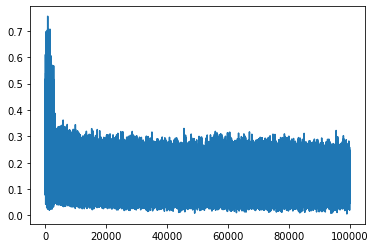

In [32]:
plt.plot(l_history1)

In [ ]:
labels[0].shape

torch.Size([32, 32, 3])

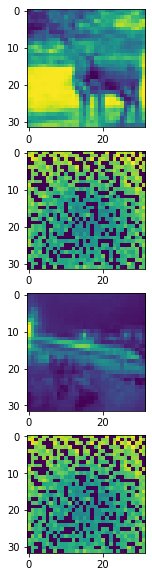

In [33]:
plt.figure(figsize=(10,10))
plt.subplot(4,1,1)
plt.imshow(np.reshape(labels[1001].cpu().detach().numpy()/255,(32,32)))
plt.subplot(4,1,2)
plt.imshow(np.reshape(decoder(datag[1001].flatten()).cpu().detach().numpy(),(32,32))/255)
plt.subplot(4,1,3)
plt.imshow(tlabels[1001].cpu().detach().numpy()/255)
plt.subplot(4,1,4)
plt.imshow(np.reshape(decoder(testg[1001].flatten()).cpu().detach().numpy(),(32,32))/255)
#decoder(decoder(testset.data[0].flatten())).cpu().detach().numpy()